# Hello, Instant RM!

Before running this notebook, please ensure Instant RM is installed by following the [instructions in the README](../README.md).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import drjit as dr
import mitsuba as mi
import numpy as np
from instant_rm import MapTracer, PathlossMapRBPTracer
import time

# Tracing radio maps

Instant RM uses [Mitsuba](https://mitsuba.readthedocs.io/en/latest/) and [Dr.Jit](https://drjit.readthedocs.io/en/latest/).
Therefore, we use Mitsuba's [scene format](https://mitsuba.readthedocs.io/en/latest/src/key_topics/scene_format.html) as well.

A few scenes are provided in the [scenes/](../scenes) folder of this repository. Let's start by loading one of them:

In [2]:
# Load the Mitsuba scene
scene = mi.load_file("../scenes/etoile/etoile.xml")

The geometry of this scene is identical to the [Etoile scene from Sionna](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.scene.etoile).
This scene contains the area around the Arc de Triomphe in Paris.
The scene was created with data downloaded from [OpenStreetMap](https://www.openstreetmap.org) and
the help of [Blender](https://www.blender.org) and the [Blender-OSM](https://github.com/vvoovv/blender-osm)
and [Mitsuba Blender](https://github.com/mitsuba-renderer/mitsuba-blender) add-ons.
The data is licensed under the [Open Data Commons Open Database License (ODbL)](https://openstreetmap.org/copyright).

![img](img/etoile.png)

Next, we need to build an instance of `MapTracer`, which is the object that traces radio maps.
This requires providing parameters that characterize the transmitter as well as the measurement plane.
The measurement plane is the rectangle that geometrically defines the surafce on which radio maps will be computed.

The transmitter is assumed to be equipped with a single and linearly polarized antenna. Here are the parameters required for building the tracer:
- `fc` : Carrier frequency [Hz]
- `tx_pattern` : Antenna pattern used by the transmitter. The following patterns are available: 'iso' 'dipole', 'hw_dipole', or 'tr38901'. These are identical to the ones available in [Sionna](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.antenna.dipole_pattern).
- `tx_slant_angle` : Slant angle of the linear polarization [rad]. A slant angle of zero means vertical polarization.
- `mp_center` : Position of the center of the measurement plane
- `mp_orientation` :  Orientation of the measurement plane specified through three angles $[\alpha, \beta, \gamma]$ corresponding to a 3D rotation defined as follows:

$$
    \mathbf{R} = \mathbf{R}_z(\alpha) \mathbf{R}_y(\beta) \mathbf{R}_x(\gamma)
$$
    where `[0,0,0]` corresponds to a measurement plane that is parallel to the XY plane.

- `mp_size` : Size of the measurement plane
- `mp_cell_size` : Size of a cell of the map
- `num_samples` : Number of rays initially shot from the transmitter
- `max_depth` : Maximum number of bounces allowed for tracing the rays
- `seed` : Seed used to initialize the tracer PRNG. Defaults to 1.
- `rr_depth` : Path depth at which Russian roulette starts to be used. See [the Section on Russian roulette](#Russian-roulette). Defaults to -1, i.e., no Russian roulette.
- `rr_prob` : If Russian roulette is used, maximum probability with which to continue a path. Defaults to 0.95.

In [3]:
# Instantiate the map tracer
tracer = MapTracer(scene,
                   fc=3.5e9,                             # Carrier frequency [Hz]
                   tx_pattern='tr38901',                 # Transmit antenna pattern
                   tx_slant_angle=0.0,                   # Slant angle for the linearly polarized antenna [rad].
                                                         # Zero means vertical polarization
                   mp_center = np.array([0., 0., 1.5]),  # Position of the center of the measurement plane
                   mp_orientation = np.array([0.,0.,0.]),# Orientation of the measurement plane [alpha, beta, gamma].
                                                         # [0,0,0] means the normal to the map is z
                   mp_size = np.array([500.,500.]),      # Size of the measurement plane
                   mp_cell_size = np.array([1.,1.]),     # Size of cells of the measurement plane
                   num_samples = int(1e7),               # Number of rays initially shot from the transmitter
                   max_depth = 10)                       # Maximum number of bounces

We are now ready to trace a radio maps! This can be achieved by calling the `tracer` object with the following inputs:
- `tx_position` : Position of the transmitter
- `tx_orientation` : Orientation of the transmitter specified through three angles $[\alpha, \beta, \gamma]$ corresponding to a 3D rotation defined as for the measurement plane.
- `los` : If set to `True`, then LoS is enabled. Defaults to `True`.
- `rms_ds` : If set to `True`, the RMS-DS map is computed. Defaults to `True`.
- `mda` : If set to `True`, the mean direction of arrival map is computed. Defaults to `True`.
- `mdd` : If set to `True`, the mean direction of departure map is computed. Defaults to `True`.
- `loop_record` :  If set to `True`, then Dr.Jit loop recording is enabled. Loop recording is significantly faster. However, with loop recording, backpropagation *across* loop iterations is not possible. See the [Section on radiative backpropagation](#Radiative-backpropagation). Default to `True`.

In [4]:
# pm : Path loss map
# rdsm : RMS DS map
# mdam : Mean direction of arrival map
# mddm : Mean direction of departure map
pm, rdsm, mdam, mddm = tracer(tx_position=np.array([0.,0.,20.]),
                              tx_orientation=np.array([np.pi, 0., 0.]))
# Cast to numpy array
pm = pm.numpy()
rdsm = rdsm.numpy()
mdam = mdam.numpy()
mddm = mddm.numpy()

print("Map size:", pm.shape)

Map size: (500, 500)


The `MapTracer` computes up to four radio maps:
- A path loss map of size `[num_cells_x, num_cells_y]`, whose entries correspond to the average path loss in each cell.
- An RMS-DS map of size `[num_cells_x, num_cells_y]`, whose entries correspond to the RMS DS in each cell. It is returned only if `rms_ds` is set to `True`.
- A mean direction of arrival map of size `[num_cells_x, num_cells_y, 3]`, whose entries correspond to the weighted average direction of arrival in each cell. It is returned only if `mda` is set to `True`.
- A mean direction of departure map of size `[num_cells_x, num_cells_y, 3]`, whose entries correspond to the weighted average direction of departure in each cell. It is returned only if `mdd` is set to `True`.

Note that the direction spread of arrival (DSA) and departure (DSD) can be computed from the average direction of arrival and departure, respectively (see Eq. (11) in [3]):

$$
\begin{aligned}
\text{DSA} &= \sqrt{1-\lVert \mathbf{k}_A\rVert^2}\\
\text{DSD} &= \sqrt{1-\lVert \mathbf{k}_D\rVert^2}
\end{aligned}
$$

where $\mathbf{k}_A$ and $\mathbf{k}_D$ are the average direction of arrival and departure, respectively, which are given for all cells by the `mdam` and `mddm` maps. For their mathematical definition, see Eq. (8) in [3].

We can now visualize radio maps using Pyplot.

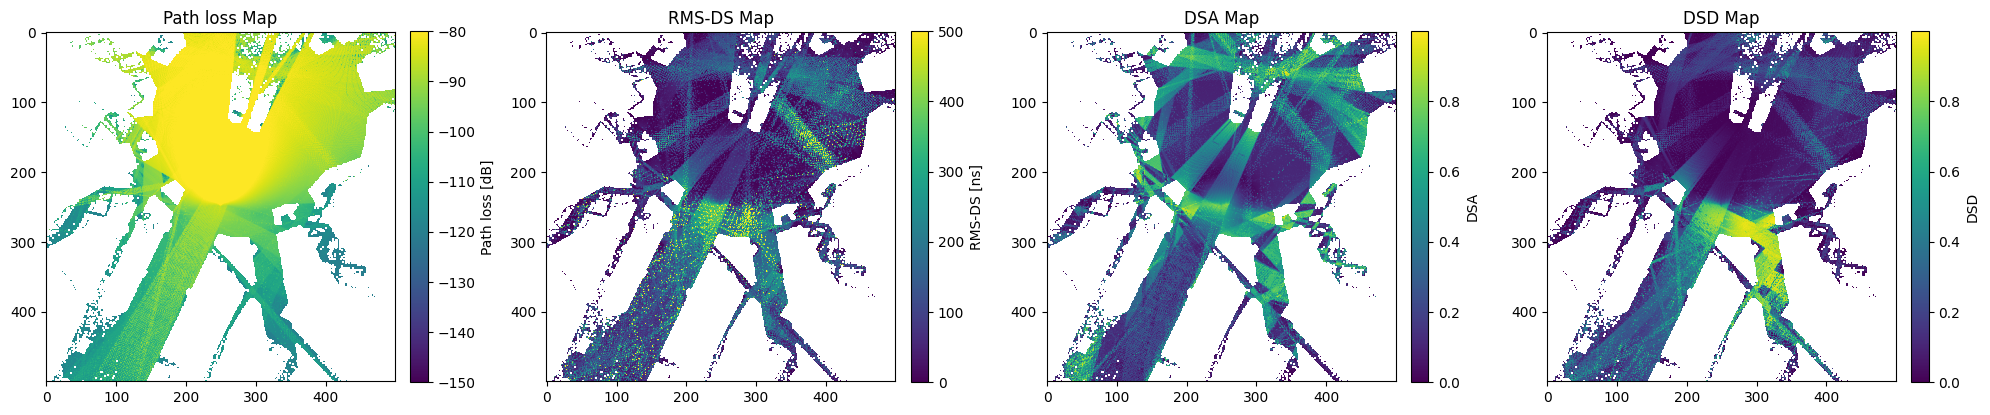

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,8))

# Plot the path loss map
ax1.set_title("Path loss Map")
# Visualize the path loss map in dB
# Cells for which path loss equal to zero have no coverage. Values for these cells are
# set to NaN for visualization.
pm_db = np.where(pm == 0., np.nan, 10.*np.log10(pm + 1e-12))
im = ax1.imshow(pm_db, vmin=-150, vmax=-80) 
plt.colorbar(im, label="Path loss [dB]", ax=ax1, fraction=0.046, pad=0.04)

# Plot the RMS-DS map
ax2.set_title("RMS-DS Map")
im = ax2.imshow(rdsm, vmax=500)
plt.colorbar(im, label="RMS-DS [ns]", ax=ax2, fraction=0.046, pad=0.04)

# Plot the DSA map
ax3.set_title("DSA Map")
# Due to numerical errors, the norm of the direction vector can be
# slightly higher than one. We clip it to (0,1) to avoid warnings.
norm_dsam = np.clip(np.linalg.norm(mdam, axis=-1), 0., 1.)
dsam = np.sqrt(1-norm_dsam**2)
im = ax3.imshow(dsam)
plt.colorbar(im, label="DSA", ax=ax3, fraction=0.046, pad=0.04)

# Plot the DSD map
ax4.set_title("DSD Map")
# Due to numerical errors, the norm of the direction vector can be
# slightly higher than one. We clip it to (0,1) to avoid warnings.
norm_dsdm = np.clip(np.linalg.norm(mddm, axis=-1), 0., 1.)
dsdm = np.sqrt(1-norm_dsdm**2)
im = ax4.imshow(dsdm)
plt.colorbar(im, label="DSD", ax=ax4, fraction=0.046, pad=0.04)

fig.tight_layout()

# Russian roulette

Russian roulette is a technique [used in computer graphics](https://www.pbr-book.org/3ed-2018/Monte_Carlo_Integration/Russian_Roulette_and_Splitting) that can significantly improve the efficiency of ray tracing by terminating rays that contribute little to the final result.

The implementation of Russian roulette in Instant RM consists in terminating a ray with probability equal to the complement of its path loss. Formally, after the $n^{\text{th}}$ bounce, the ray path loss is set to:

$$
a_n \leftarrow
\begin{cases}
\frac{a_n}{|a_n|^2},  & \text{with probability } \min \{ p_{c},|a_n|^2 \}\\
0, & \text{with probability } 1 - \min \{ p_{c},|a_n|^2 \}
\end{cases}
$$

where $a_n$ is the path coefficient corresponding to the ray and $p_c$ the maximum probability with which to continue a path.
The first case consists in continuing the ray, whereas the second case consists in terminating the ray. When the ray is continued, the scaling by $\frac{1}{|a_n|^2}$ ensures an unbiased map by accounting for the rays that were terminated. When a ray is terminated, it is no longer traced, leading to a reduction of the required computations.

Russian roulette is by default disabled in Instant RM. It can be enabled by setting the ``rr_depth`` parameter to a positive value when building the tracer. ``rr_depth`` corresponds to the path depth, i.e., the number of bounces, from which on Russian roulette is enabled. We recommend a value of at 5 or more to ensure that Russian roulette does not add significant noise to the traced maps. Moreover, the maximum probability with which to continue a path $p_c$ can be specified using the parameter ``rr_prob``.

Let's compare the average rates at which Instant RM computes radio maps with and without Russian roulette (the speed-up is highly dependent on the scene and hardware):

In [6]:
# Instantiate the map tracer without Russian roulette
tracer = MapTracer(scene, fc=3.5e9, tx_pattern='tr38901', tx_slant_angle=0.0, mp_center = np.array([0., 0., 1.5]),
                   mp_orientation = np.array([0.,0.,0.]), mp_size = np.array([500.,500.]), mp_cell_size = np.array([1.,1.]),
                   num_samples = int(1e7), max_depth = 10,
                   rr_depth = -1) # Russian roulette disabled

# Average over a few iterations
num_iterations = 1000
start = time.time()
for _ in range(num_iterations):
    maps = tracer(tx_position=np.array([0.,0.,20.]), tx_orientation=np.array([np.pi, 0., 0.]))
    # Ensure all radio maps are evaluated
    for m in maps:
        dr.eval(m)
# Ensure compute is done
dr.sync_thread()
end = time.time()
latency = (end-start)/num_iterations
print(f"Rate without Russian roulette: {1./latency:.3f} Map/s")
pm_no_rr = maps[0].numpy()
pm_no_rr = np.where(pm_no_rr == 0., np.nan, 10.*np.log10(pm_no_rr + 1e-12))

# Instantiate the map tracer without Russian roulette
tracer = MapTracer(scene, fc=3.5e9, tx_pattern='tr38901', tx_slant_angle=0.0, mp_center = np.array([0., 0., 1.5]),
                   mp_orientation = np.array([0.,0.,0.]), mp_size = np.array([500.,500.]), mp_cell_size = np.array([1.,1.]),
                   num_samples = int(1e7), max_depth = 10,
                   rr_depth = 5) # Russian roulette enabled from the 5th bounce

# Average over a few iterations
num_iterations = 1000
start = time.time()
for _ in range(num_iterations):
    maps = tracer(tx_position=np.array([0.,0.,20.]), tx_orientation=np.array([np.pi, 0., 0.]))
    # Ensure all radio maps are evaluated
    for m in maps:
        dr.eval(m)
# Ensure compute is done
dr.sync_thread()
end = time.time()
latency = (end-start)/num_iterations
print(f"Rate with Russian roulette: {1./latency:.3f} Map/s")
pm_rr = maps[0].numpy()
pm_rr = np.where(pm_rr == 0., np.nan, 10.*np.log10(pm_rr + 1e-12))

Rate without Russian roulette: 89.674 Map/s
Rate with Russian roulette: 108.196 Map/s


We can visualize the noise introduced by Russian roulette by computing the absolute logarithmic error (ALE) between the path loss maps.
The error is generally larger in areas that can only be reached by rays going through many bounces.

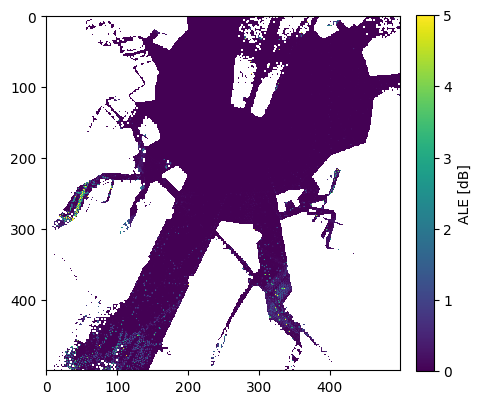

In [7]:
ale_db = np.abs(pm_rr - pm_no_rr)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
im = ax.imshow(ale_db, vmax=5)
plt.colorbar(im, label="ALE [dB]", fraction=0.046, pad=0.04);

# Computing gradients

Instant RM is fully differentiable, i.e., it enables the computation of gradients with respect to most of the scene parameters.

We can access the scene parameters using the [mitsuba.traverse()](https://mitsuba.readthedocs.io/en/latest/src/rendering/editing_a_scene.html#Accessing-scene-parameters) utility.

In [8]:
params = mi.traverse(scene)
params

SceneParameters[
  -------------------------------------------------------------------------------------------------------------------
  Name                                                            Flags    Type  Parent
  -------------------------------------------------------------------------------------------------------------------
  mat-itu_concrete.eta_r                                          ∂        Float BSDF
  mat-itu_concrete.eta_i                                          ∂        Float BSDF
  mat-itu_wood.eta_r                                              ∂        Float BSDF
  mat-itu_wood.eta_i                                              ∂        Float BSDF
  mat-itu_marble.eta_r                                            ∂        Float BSDF
  mat-itu_marble.eta_i                                            ∂        Float BSDF
  mat-itu_metal.eta_r                                             ∂        Float BSDF
  mat-itu_metal.eta_i                                    

The table above provides the parameters name, type, parent type, and flags. The '$\partial$' flag indicates that the parameter is differentiable, and the `D` flag indicates that its gradient presents discontinuities. This utility is therefore convenient to check which scene parameters are differentiable.

We can access values of the parameters by indexing `params` like a Python dictionnary:


In [9]:
params['mat-itu_concrete.eta_r']

[5.239999771118164]

Let's now build the tracer.

In [10]:
# Instantiate the map tracer
tracer = MapTracer(scene, fc=3.5e9, tx_pattern='tr38901', tx_slant_angle=0.0,
                   mp_center = np.array([0., 0., 1.5]), mp_orientation = np.array([0.,0.,0.]),
                   mp_size = np.array([500.,500.]), mp_cell_size = np.array([10.,10.]), num_samples = int(1e6),
                   max_depth = 10, rr_depth=5)

We next define a loss function that takes as input the radio maps. In this example, we consider a loss function that only uses the path loss map and simply computes the negative of the average path loss over all cells in dB. The negative is returned since we will be performing gradient *descent*.

In [11]:
def n_avg_pathloss(pm):
    "NegativeaAverage power in dB"
    return -10.0*dr.log(dr.mean(pm))/dr.log(10.)

Next, we need to define an optimizer. We use Adam with a learning rate of $10^{-3}$:

In [12]:
opt = mi.ad.Adam(lr=1e-3)
opt

Adam[
  variables = [],
  lr = {'default': 0.001},
  betas = (0.9, 0.999),
  eps = 1e-08
]

To enable gradient computation w.r.t. to a variable, we need to add it to the list of variables to be optimized by `opt`.
In this example, we will compute the gradient of the real component of the relative permittivity of the `itu_concrete` material.

We start by creating a trainable variable. This is done in the following cell by instantiating a Mitsuba float and adding it to the list of variables tracked by `opt`.

In [13]:
opt['my_trainable_variable'] = mi.Float(2.0)

We then use the created variable as the real component of the complex relative permittivity of `itu_concrete`.

In [14]:
params['mat-itu_concrete.eta_r'] = opt['my_trainable_variable']
params.update(); # Apply the change

Let's now compute the gradient with respect to this variable.

We first run the forward pass by tracing the path loss map and computing the loss function.
Note that the Dr.Jit loop recording is disabled to compute backpropagation, which significantly increases the latency.
This issue is adressed in the next section by using radiative backpropagation.

In [15]:
pm,  = tracer(tx_position=np.array([0.,0.,20.]), tx_orientation=np.array([np.pi, 0., 0.]),
              loop_record=False, rms_ds=False, mda=False, mdd=False)

loss = n_avg_pathloss(pm)
print("Loss value", loss)

Loss value [85.19775390625]


Computing the gradient using a backward pass is achieved by calling [drjit.backward()](https://drjit.readthedocs.io/en/latest/reference.html#drjit.backward) on the loss value.

In [16]:
dr.backward(loss)

Note that Dr.Jit does not return the gradients, but stores them internally.
The gradients can however still be retrieved by calling [drjit.grad()](https://drjit.readthedocs.io/en/latest/reference.html#drjit.grad):

In [17]:
dr.grad(opt['my_trainable_variable']).numpy()

array([0.08891843], dtype=float32)

Applying a gradient step using the instantiated optimizer is achieved as follows:

In [18]:
opt.step()

We can then observe that the value of the trainable variable has been updated:

In [19]:
opt['my_trainable_variable']

[1.9989999532699585]

Let's now run a few iterations of gradient descent in a training loop and measure the average iteration rate

In [20]:
# Number of iterations
num_iterations = 30

start = time.time()
for _ in range(num_iterations):

    # Forward pass
    pm, = tracer(tx_position=np.array([0.,0.,20.]), tx_orientation=np.array([np.pi, 0., 0.]),
                 loop_record=False, rms_ds=False, mda=False, mdd=False)

    # Loss function
    loss = n_avg_pathloss(pm)

    # Backward pass
    dr.backward(loss)

    # Gradient descent step
    opt.step()

    # Update scene variable
    params[f"mat-itu_concrete.eta_r"] = opt['my_trainable_variable']
    params.update()
end = time.time()
dr.sync_thread() # Ensures compute is over when stoping the timer
latency = (end-start)/num_iterations

print(f"Rate: {1./latency:.3f} Iterations/s")

Rate: 1.623 Iterations/s


Te value of the trainable variable has changed:

In [21]:
opt['my_trainable_variable']

[1.969720482826233]

# Radiative backpropagation

The [previous section](#Computing-gradients) uses conventional auto-differentiation to compute gradients. This approach, however, suffers from prohibitive computational and memory complexity, and therefore does not scale to even moderately high number of bounces (`max_depth`) or paths (`num_samples`).
To address these drawbacks, radiative backpropagation (RBP) [1,2] was proposed in the field of computer graphics as an alternative to conventional auto-differentiation.

We have derived an RBP-based algorithm for the differentiation of radio maps, and provide an implementation of our algorithm as part of this repository. To enable RBP, you can simply use the `PathlossMapRBPTracer`.
Note that RBP is currently only available for path loss maps.

The parameters required to build the `PathlossMapRBPTracer` are identical to the ones of the `MapTracer`.

In [22]:
# Instantiate the path loss map RBP tracer
# Parameters are identical to `MapTracer`
tracer = PathlossMapRBPTracer(scene, fc=3.5e9, tx_pattern='tr38901', tx_slant_angle=0.0, mp_center = np.array([0., 0., 1.5]),
                              mp_orientation = np.array([0.,0.,0.]), mp_size = np.array([500.,500.]), mp_cell_size = np.array([10.,10.]),
                              num_samples = int(1e6), max_depth = 10, rr_depth=5)

Next, we define the optimizer and the trainable variable

In [23]:
# Adam optimizer with learning rate 10^-3
opt = mi.ad.Adam(lr=1e-3)

# Define a trainable variable
opt['my_trainable_variable'] = mi.Float(2.0)
params['mat-itu_concrete.eta_r'] = opt['my_trainable_variable']
params.update(); # Apply the change

We are now ready to perform the forward and backward pass.
This is achieve through a single call to the `tracer` object.
There is therefore no need to compute the gradients using `dr.backward()`, as it is done when calling the `tracer`.

In [24]:
pm,loss = tracer(tx_position=np.array([0.,0.,20.]),
                 tx_orientation=np.array([np.pi, 0., 0.]),
                 func_loss=n_avg_pathloss, # Need to specify the loss function.
                 loop_record=True) # Loop record works with RBP :)
print("Loss value", loss)

Loss value [85.19705963134766]


The `PathlossMapRBPTracer` returns the path loss map and the value of the loss.

We can check that the gradients have been computed

In [25]:
dr.grad(opt['my_trainable_variable']).numpy()

array([0.08890475], dtype=float32)

Finally, we can apply a gradient descent step using the optimizer, and check the value of the updated variable.

In [26]:
opt.step()
opt['my_trainable_variable']

[1.9989999532699585]

Let's now run a few iterations of gradient descent in a training loop and measure the average iteration rate:

In [27]:
# Number of iterations
num_iterations = 30

start = time.time()
for _ in range(num_iterations):

    # Forward and backward step
    _,loss = tracer(tx_position=np.array([0.,0.,20.]), tx_orientation=np.array([np.pi, 0., 0.]),
                     func_loss=n_avg_pathloss, loop_record=True)

    # Gradient descent step
    opt.step()

    # Update scene variable
    params[f"mat-itu_concrete.eta_r"] = opt['my_trainable_variable']
    params.update()
end = time.time()
dr.sync_thread() # Ensures compute is over when stoping the timer
latency = (end-start)/num_iterations

print(f"Rate: {1./latency:.3f} Iterations/s")

Rate: 15.214 Iterations/s


Let's have a look at the value of the trainable variable

In [28]:
opt['my_trainable_variable']

[1.969720482826233]

We've reached the end of our tutorial. For more advanced uses of differentiable radio maps, you can check-out our examples on [calibration](Calibration.ipynb) and [differentiable geometry]().

# References

[1] Merlin Nimier-David, Sébastien Speierer, Benoît Ruiz, and Wenzel Jakob, ["Radiative backpropagation: an adjoint method for lightning-fast differentiable rendering"](https://rgl.epfl.ch/publications/NimierDavid2020Radiative), ACM Trans. Graph. 39, 4, Article 146 (August 2020), 15 pages.

[2] Delio Vicini, Sébastien Speierer, and Wenzel Jakob, ["Path replay backpropagation: differentiating light paths using constant memory and linear time"](https://rgl.epfl.ch/publications/Vicini2021PathReplay), ACM Trans. Graph. 40, 4, Article 108 (August 2021), 14 pages.

[3] B.H. Fleury, ["First- and second-order characterization of direction dispersion and space selectivity in the radio channel"](https://ieeexplore.ieee.org/abstract/document/868476), IEEE Trans. Inf. Theory, vol. 46, no. 6, Sep. 2000, pp. 2027 - 2044. 